In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -o '/content/drive/MyDrive/BDM_PROJECT/data.zip'

In [ ]:
# !cp '/content/drive/MyDrive/BDM_PROJECT/disease_new_aug.keras' .

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=30,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
train_dataset = train_datagen.flow_from_directory(directory='./dataset_split/train',
                                  target_size=(224,224),
                                  class_mode='categorical',
                                  batch_size=128)

test_dataset = train_datagen.flow_from_directory(directory='./dataset_split/test',
                                  target_size=(224,224),
                                  class_mode='categorical',
                                  batch_size=128,
                                  shuffle=False)

valid_dataset = train_datagen.flow_from_directory(directory='./dataset_split/val',
                                  target_size=(224,224),
                                  class_mode='categorical',
                                  batch_size=128)

Found 46735 images belonging to 93 classes.
Found 10082 images belonging to 93 classes.
Found 9990 images belonging to 93 classes.


In [ ]:
num_classes = train_dataset.num_classes

In [ ]:
disease_cls  = train_dataset.class_indices

In [ ]:
# import json

In [ ]:
# with open('data_class.json', 'w') as f:
#   f.write(str(disease_cls))

In [ ]:
images, labels = next(train_dataset)

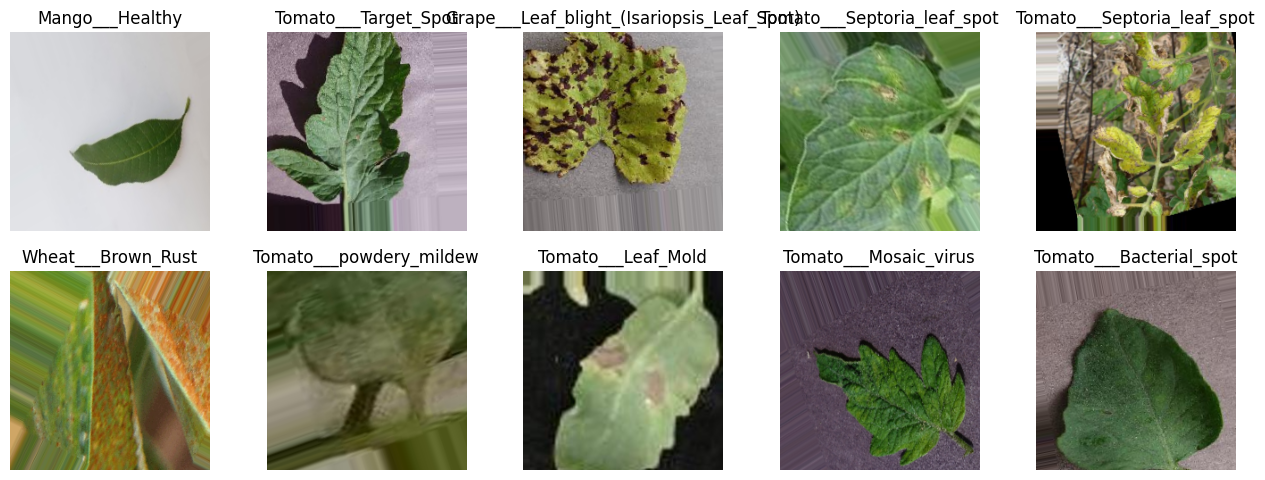

In [ ]:
reverse_disease_cls = {v:k for k,v in disease_cls.items()}
plt.figure(figsize=(16,15))

for i in range(10):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    label = np.argmax(labels[i])
    plt.title(reverse_disease_cls[label])
    plt.gca().set_axis_off()

plt.show()

In [ ]:
from keras.applications import ResNet101V2, VGG19, EfficientNetB0, EfficientNetB7, MobileNetV2

In [ ]:
VGG = MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
for layers in VGG.layers:
    layers.trainable = False

In [ ]:
model = keras.Sequential([
    VGG,
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62720)               │         250,880 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │     128,452,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 93)                  │          95,325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,167,261 (507.99 MB)

 Trainable params: 130,777,693 (498.88 MB)

 Non-trainable params: 2,389,568 (9.12 MB)

In [ ]:
METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

In [ ]:
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


366/366 ━━━━━━━━━━━━━━━━━━━━ 1126s 3s/step - accuracy: 0.6493 - loss: 1.3560 - precision: 0.7528 - recall: 0.5836 - val_accuracy: 0.8231 - val_loss: 0.5710 - val_precision: 0.8524 - val_recall: 0.8007
Epoch 2/5
366/366 ━━━━━━━━━━━━━━━━━━━━ 1076s 3s/step - accuracy: 0.8270 - loss: 0.5255 - precision: 0.8668 - recall: 0.7981 - val_accuracy: 0.8564 - val_loss: 0.4476 - val_precision: 0.8837 - val_recall: 0.8335
Epoch 3/5
366/366 ━━━━━━━━━━━━━━━━━━━━ 1004s 3s/step - accuracy: 0.8549 - loss: 0.4332 - precision: 0.8868 - recall: 0.8278 - val_accuracy: 0.8574 - val_loss: 0.4266 - val_precision: 0.8853 - val_recall: 0.8382
Epoch 4/5
366/366 ━━━━━━━━━━━━━━━━━━━━ 1097s 3s/step - accuracy: 0.8712 - loss: 0.3770 - precision: 0.8977 - recall: 0.8504 - val_accuracy: 0.8670 - val_loss: 0.4012 - val_precision: 0.8913 - val_recall: 0.8502
Epoch 5/5
366/366 ━━━━━━━━━━━━━━━━━━━━ 1109s 3s/step - accuracy: 0.8834 - loss: 0.3406 - precision: 0.9086 - recall: 0.8632 - val_accuracy: 0.8803 - val_loss: 0.3681 

In [ ]:
model.evaluate(test_dataset)

79/79 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.9005 - loss: 0.3188 - precision: 0.9199 - recall: 0.8885


[0.3427422046661377,
 0.8857369422912598,
 0.9090909361839294,
 0.8698670864105225]

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('disease_new.keras')  # If you saved the model
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=5)


Epoch 1/5
366/366 ━━━━━━━━━━━━━━━━━━━━ 521s 1s/step - accuracy: 0.9863 - loss: 0.0444 - precision: 0.9874 - recall: 0.9853 - val_accuracy: 0.8752 - val_loss: 0.6185 - val_precision: 0.8838 - val_recall: 0.8696
Epoch 2/5
 18/366 ━━━━━━━━━━━━━━━━━━━━ 6:54 1s/step - accuracy: 0.9881 - loss: 0.0379 - precision: 0.9881 - recall: 0.9877

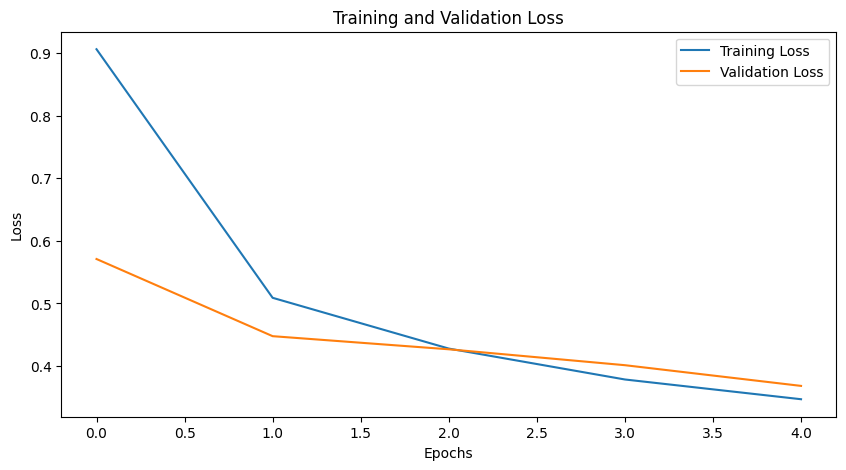

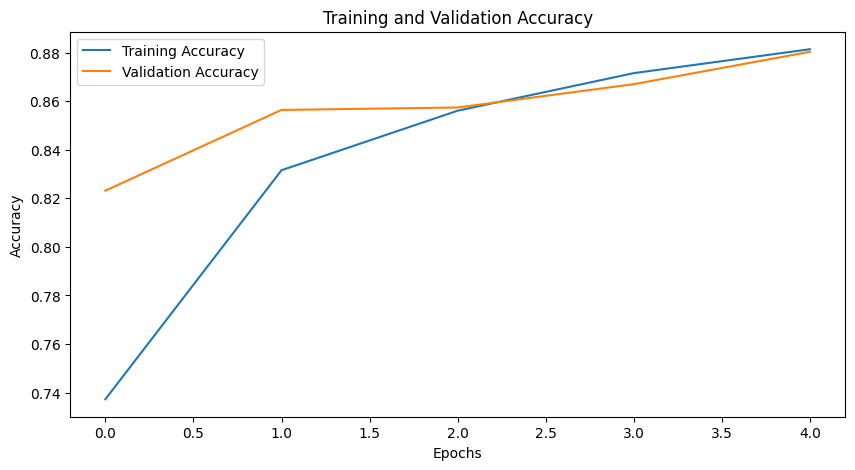

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/BDM_PROJECT/disease_mobile.keras')

In [ ]:
model.save('disease_mobile.keras')

In [ ]:
!ls -lah

total 691M
drwxr-xr-x 1 root root 4.0K Jan 14 11:38 .
drwxr-xr-x 1 root root 4.0K Jan 14 09:44 ..
drwxr-xr-x 4 root root 4.0K Jan  9 14:24 .config
drwxr-xr-x 5 root root 4.0K Jan  3 11:42 dataset_split
-rw-r--r-- 1 root root 691M Jan 14 11:38 disease_vgg.keras
drwx------ 7 root root 4.0K Jan 14 09:48 drive
drwxr-xr-x 1 root root 4.0K Jan  9 14:24 sample_data


In [ ]:
test_images, test_labels = next(test_dataset)

In [ ]:
predictions = model.predict(test_images[:20])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [ ]:
predicted_labels = [np.argmax(i) for i in predictions]

In [ ]:
actual_labels = [np.argmax(i) for i in test_labels]

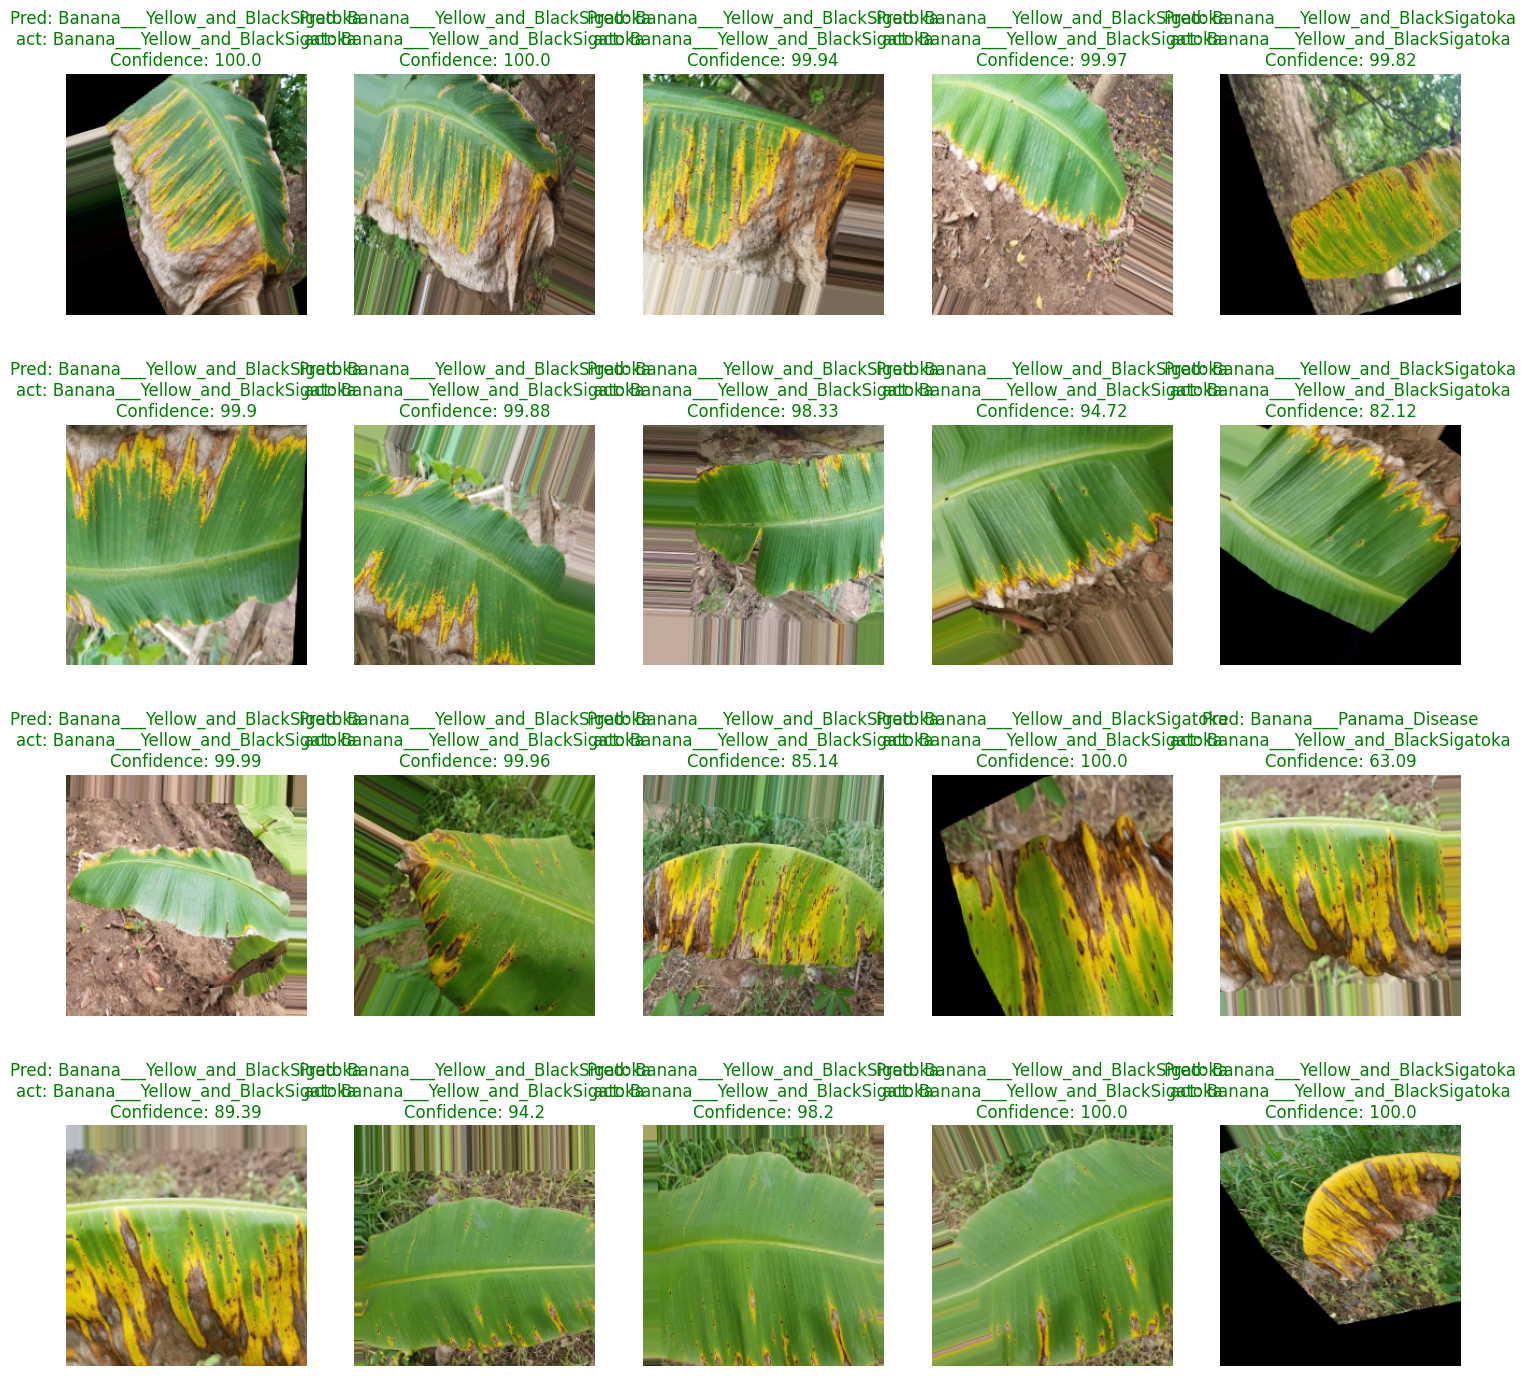

In [ ]:
plt.figure(figsize=(18,22))

for i in range(20):
    ax = plt.subplot(5,5,i+1)
    ax.imshow(test_images[:20][i])
    predicted_label = predicted_labels[i]
    actual_label = actual_labels[i]
    confidence = round(np.max(predictions[i]) * 100,2)
    ax.set_title(f'Pred: {reverse_disease_cls[predicted_label]}\nact: {reverse_disease_cls[actual_label]}\nConfidence: {confidence}',color='green')
    ax.set_axis_off()
    # print(np.max(predictions[i]))

plt.show()

In [ ]:
image = cv2.imread('images.jpg')
resized_image = cv2.resize(image, (224,224))

In [ ]:
input_data = np.expand_dims(resized_image, axis=0)

In [ ]:
data = model.predict(input_data/255)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [ ]:
reverse_disease_cls[np.argmax(data)]

'Peach___Bacterial_spot'

In [ ]:
np.max(data, axis=1)

array([0.35172284], dtype=float32)

In [ ]:
model.load_weights('disease_mobile.keras')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━

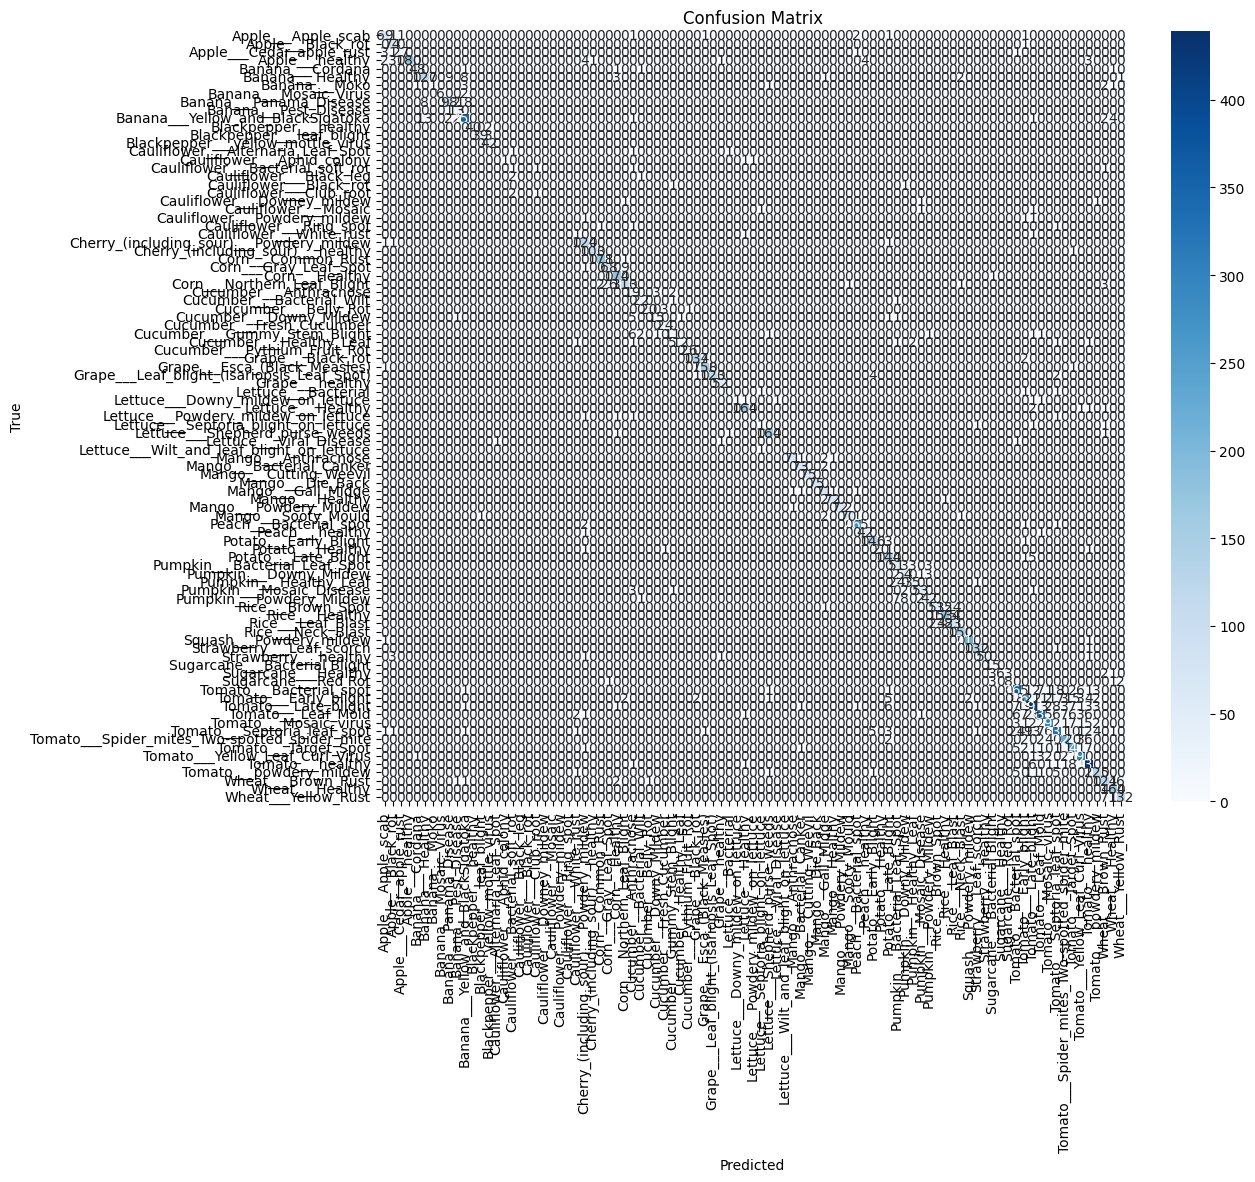

In [ ]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    # Predict probabilities
    predictions = model.predict(images)
    # Convert to class labels
    predicted_classes = np.argmax(predictions, axis=1)
    # Append true and predicted labels
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(predicted_classes)
    # Break loop if all batches are processed
    if len(y_true) >= test_dataset.samples:
        break

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 2: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
classes = list(disease_cls.keys())

# Step 3: Visualize confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Top Misclassified Classes:
True: Rice___Leaf_Blast, Predicted: Rice___Healthy, Count: 42
True: Rice___Healthy, Predicted: Rice___Leaf_Blast, Count: 34
True: Corn___Northern_Leaf_Blight, Predicted: Corn___Gray_Leaf_Spot, Count: 26
True: Tomato___Leaf_Mold, Predicted: Tomato___Late_blight, Count: 26
True: Pumpkin___Healthy_Leaf, Predicted: Pumpkin___Bacterial_Leaf_Spot, Count: 24
True: Rice___Brown_Spot, Predicted: Rice___Leaf_Blast, Count: 24
True: Tomato___Septoria_leaf_spot, Predicted: Tomato___Bacterial_spot, Count: 24
True: Rice___Leaf_Blast, Predicted: Rice___Brown_Spot, Count: 23
True: Tomato___Early_blight, Predicted: Tomato___Late_blight, Count: 22
True: Tomato___Spider_mites_Two-spotted_spider_mite, Predicted: Tomato___Target_Spot, Count: 20


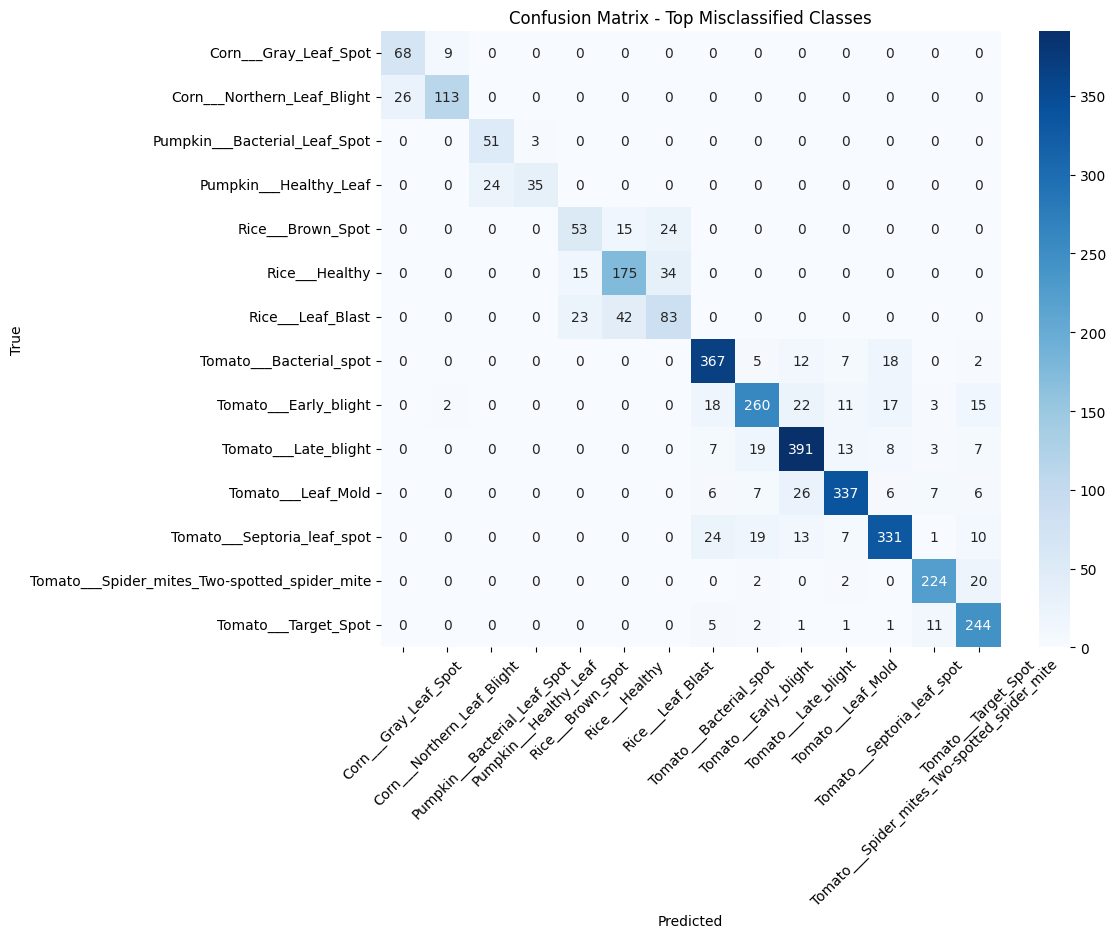

In [ ]:
# Identify the top misclassified pairs
misclassifications = cm - np.eye(len(classes)) * cm.diagonal()
misclassifications_flat = [(i, j, misclassifications[i, j])
                           for i in range(len(classes))
                           for j in range(len(classes)) if i != j]

# Sort by count
misclassifications_flat = sorted(misclassifications_flat, key=lambda x: x[2], reverse=True)

# Select top misclassifications
top_misclassified = misclassifications_flat[:10]

# Print top misclassified
print("Top Misclassified Classes:")
for true_idx, pred_idx, count in top_misclassified:
    print(f"True: {classes[true_idx]}, Predicted: {classes[pred_idx]}, Count: {int(count)}")

# Extract indices of top misclassified classes
indices_to_plot = set(i for i, _, _ in top_misclassified).union(
                  j for _, j, _ in top_misclassified)

# Subset confusion matrix
subset_classes = [classes[i] for i in sorted(indices_to_plot)]
subset_cm = cm[np.ix_(sorted(indices_to_plot), sorted(indices_to_plot))]

plt.figure(figsize=(10, 8))
sns.heatmap(subset_cm, annot=True, fmt='d', cmap='Blues', xticklabels=subset_classes, yticklabels=subset_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Top Misclassified Classes')
plt.xticks(rotation=45)
plt.show()


In [ ]:
print(classification_report(y_true, y_pred, target_names=classes))

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.88      0.90      0.89        77
                            Apple___Black_rot       0.88      0.99      0.93        75
                     Apple___Cedar_apple_rust       0.96      0.82      0.89        33
                              Apple___healthy       1.00      0.91      0.95       198
                             Banana___Cordana       0.96      0.92      0.94        52
                             Banana___Healthy       0.86      0.84      0.85       151
                                Banana___Moko       1.00      0.11      0.20         9
                        Banana___Mosaic_Virus       1.00      0.75      0.86         8
                      Banana___Panama_Disease       0.89      0.78      0.83       126
                        Banana___Pest_Disease       0.68      0.93      0.79        14
            Banana___Yellow_and_BlackSigat

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=list(range(len(classes))))
y_pred_prob = model.predict(test_dataset)

# Compute AUC for each class
auc_scores = roc_auc_score(y_true_bin, y_pred_prob, average=None)
for i, score in enumerate(auc_scores):
    print(f"Class {classes[i]}: AUC = {score:.2f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step
Class Apple___Apple_scab: AUC = 0.36
Class Apple___Black_rot: AUC = 0.34
Class Apple___Cedar_apple_rust: AUC = 0.35
Class Apple___healthy: AUC = 0.55
Class Banana___Cordana: AUC = 0.27
Class Banana___Healthy: AUC = 0.67
Class Banana___Moko: AUC = 0.86
Class Banana___Mosaic_Virus: AUC = 0.69
Class Banana___Panama_Disease: AUC = 0.63
Class Banana___Pest_Disease: AUC = 0.50
Class Banana___Yellow_and_BlackSigatoka: AUC = 0.65
Class Blackpepper___healthy: AUC = 0.52
Class Blackpepper___leaf_blight: AUC = 0.51
Class Blackpepper___yellow_mottle_virus: AUC = 0.50
Class Cauliflower___Alternaria_Leaf_Spot: AUC = 0.30
Class Cauliflower___Aphid_colony: AUC = 0.19
Class Cauliflower___Bacterial_soft_rot: AUC = 0.59
Class Cauliflower___Black_leg: AUC = 0.18
Class Cauliflower___Black_rot: AUC = 0.28
Class Cauliflower___Club_root: AUC = 0.29
Class Cauliflower___Downey_mildew: AUC = 0.44
Class Cauliflower___Mosaic: AUC = 0.22
Class Cauliflower___Powdery_mildew: AU

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=list(range(len(classes))))
y_pred_prob = model.predict(test_dataset)

# Compute AUC for each class
auc_scores = roc_auc_score(y_true_bin, y_pred_prob, average=None)
for i, score in enumerate(auc_scores):
    print(f"Class {classes[i]}: AUC = {score:.2f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step
Class Apple___Apple_scab: AUC = 1.00
Class Apple___Black_rot: AUC = 1.00
Class Apple___Cedar_apple_rust: AUC = 1.00
Class Apple___healthy: AUC = 1.00
Class Banana___Cordana: AUC = 1.00
Class Banana___Healthy: AUC = 1.00
Class Banana___Moko: AUC = 1.00
Class Banana___Mosaic_Virus: AUC = 1.00
Class Banana___Panama_Disease: AUC = 1.00
Class Banana___Pest_Disease: AUC = 1.00
Class Banana___Yellow_and_BlackSigatoka: AUC = 1.00
Class Blackpepper___healthy: AUC = 1.00
Class Blackpepper___leaf_blight: AUC = 1.00
Class Blackpepper___yellow_mottle_virus: AUC = 1.00
Class Cauliflower___Alternaria_Leaf_Spot: AUC = 0.99
Class Cauliflower___Aphid_colony: AUC = 1.00
Class Cauliflower___Bacterial_soft_rot: AUC = 0.98
Class Cauliflower___Black_leg: AUC = 1.00
Class Cauliflower___Black_rot: AUC = 1.00
Class Cauliflower___Club_root: AUC = 1.00
Class Cauliflower___Downey_mildew: AUC = 0.99
Class Cauliflower___Mosaic: AUC = 1.00
Class Cauliflower___Powdery_mildew: AU

In [ ]:
# Fine-tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=10,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")
